In [19]:
import nltk
import numpy as np
import pandas as pd
import string
import re 
import time 
from collections import Counter
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import calendar
from sklearn.preprocessing import MinMaxScaler 
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import ExtraTreesClassifier
from scipy.signal import argrelextrema
from scipy.stats import gaussian_kde


In [20]:
orig_merged_df = pd.read_csv('merged_df.csv')

merged_df = orig_merged_df.copy()

In [21]:
merged_df.columns

Index(['betTimestamp', 'odds_units', 'stake_gbp', 'count_legs',
       'hours_to_event', 'betDate', 'edge', 'encrypted_user_no', 'insert_date',
       'riskexposureprematch', 'betTimestamp_diff', 'odds_units_diff',
       'stake_gbp_diff', 'count_legs_diff', 'hours_to_event_diff',
       'riskexposureprematch_diff', 'total_bets', 'avg_riskexposureprematch',
       'avg_odds_units', 'avg_stake_gbp', 'total_stake_gbp', 'month', 'day',
       'day_of_week', 'hour', 'bet_sequence_count', 'total_bets_in_sequence',
       'total_bets_until_now', 'avg_riskexposureprematch_until_now',
       'avg_odds_units_until_now', 'avg_count_legs_until_now',
       'avg_stake_gbp_until_now', 'total_stake_gbp_until_now',
       'std_stake_gbp_until_now', 'bets_in_last_1_week(s)',
       'bets_in_last_2_week(s)', 'bets_in_last_3_week(s)',
       'bets_in_last_4_week(s)', 'num_sequences_until_now',
       'num_bets_in_prev_sequence', 'time_diff_of_riskexposure'],
      dtype='object')

# Labelling Process

Need to consider all features (raw/engineered, aggregated until that bet/over all bets) to get the most accurate labels to create train/test/validation datasets.

For labelling purposes, I've reduced dataframe size to make plotting easier. I have only included the latest aggregated record for each sequence of bets.

In [4]:
# ### Attempt to reduce dataframe size as plotting is taking ages

# merged_df.drop_duplicates(inplace=True)

# ### Keep last record before change in 'riskexposureprematch' and plot on these

# # Sort the DataFrame by 'encrypted_user_no' and 'riskexposureprematch'
# merged_df.sort_values(['encrypted_user_no', 'riskexposureprematch'], inplace=True)

# # Create a new column that represents the next 'riskexposureprematch' for each user
# merged_df['next_riskexposureprematch'] = merged_df.groupby('encrypted_user_no')['riskexposureprematch'].shift(-1)

# # Filter the rows where 'riskexposureprematch' is not equal to 'next_riskexposureprematch'
# plot_df = merged_df[merged_df['riskexposureprematch'] != merged_df['next_riskexposureprematch']]

# # Remove the auxiliary column
# plot_df.drop('next_riskexposureprematch', axis=1, inplace=True)
# merged_df.drop('next_riskexposureprematch', axis=1, inplace=True)


# plot_df.drop_duplicates(inplace=True)

/var/folders/yz/86sy0w0519d250z0rfq2qx5w0000gp/T/ipykernel_11108/424635159.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df.drop('next_riskexposureprematch', axis=1, inplace=True)
/var/folders/yz/86sy0w0519d250z0rfq2qx5w0000gp/T/ipykernel_11108/424635159.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df.drop_duplicates(inplace=True)


In [22]:
print(plot_df.shape)
plot_df.head()

(33891, 41)


betTimestamp  odds_units  stake_gbp  count_legs  hours_to_event  \
0    2023-01-11 17:42:00       13.35       4.43           7        5.157143   
183  2023-04-18 12:48:54       23.08       4.41           6        6.018333   
212  2023-05-01 21:30:10       23.44       8.80           5       21.347222   
384  2023-04-24 12:33:48       30.00       0.90           1       13.436667   
456  2023-03-29 20:23:11        1.83      23.37           1        3.113611   

        betDate      edge                                encrypted_user_no  \
0    2023-01-11  0.000000  b"  \x88\r!v\xc3\x14\x13\x1dy\x80\xea\x17\xf0'"   
183  2023-04-18  0.000000  b"  \x88\r!v\xc3\x14\x13\x1dy\x80\xea\x17\xf0'"   
212  2023-05-01  0.000000  b"  \x88\r!v\xc3\x14\x13\x1dy\x80\xea\x17\xf0'"   
384  2023-04-24  0.000000      b" \xb9\xa7\xf2\xa3\xd7qkAj}'\x8e\x87\x13<"   
456  2023-03-29  0.296983   b" \xe7\xd0\xa5bQ\xda\xf3T{\xa86'\xb5\xb5\x08"   

             insert_date  riskexposureprematch  ...  avg_stake_gbp_until_now  \
0                    NaN                  1.00  ...                 4.430000   
183  2023-01-11 18:25:15                  2.99  ...                 2.589402   
212  2023-04-19 11:20:36                  3.00  ...                 2.994085   
384                  NaN                  1.00  ...                 1.480640   
456  2023-03-26 23:22:14                  0.95  ...                12.095833   

     total_stake_gbp_until_now  std_stake_gbp_until_now  \
0                         4.43                 4.200098   
183                     476.45                 4.200098   
212                     637.74                 4.200098   
384                     254.67                 1.587703   
456                     870.90                11.520422   

     bets_in_last_1_week(s)  bets_in_last_2_week(s)  bets_in_last_3_week(s)  \
0                       1.0                     1.0                     1.0   
183                    14.0                    27.0                    37.0   
212                    17.0                    33.0                    43.0   
384                    15.0                    27.0                    27.0   
456                    19.0                    29.0                    31.0   

     bets_in_last_4_week(s)  num_sequences_until_now  \
0                       1.0                        1   
183                    52.0                        2   
212                    56.0                        3   
384                    27.0                        4   
456                    62.0                        6   

     num_bets_in_prev_sequence  time_diff_of_riskexposure  
0                          1.0                        0.0  
183                        2.0                        0.0  
212                      185.0                        0.0  
384                        1.0                        0.0  
456                       63.0                        0.0  

[5 rows x 41 columns]

/opt/miniconda3/envs/DSML00/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log1p
  result = func(self.values, **kwargs)
/opt/miniconda3/envs/DSML00/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)
/var/folders/yz/86sy0w0519d250z0rfq2qx5w0000gp/T/ipykernel_11108/1753429941.py:24: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=log_plot_df, x=feature, ax=axs[i, 2])


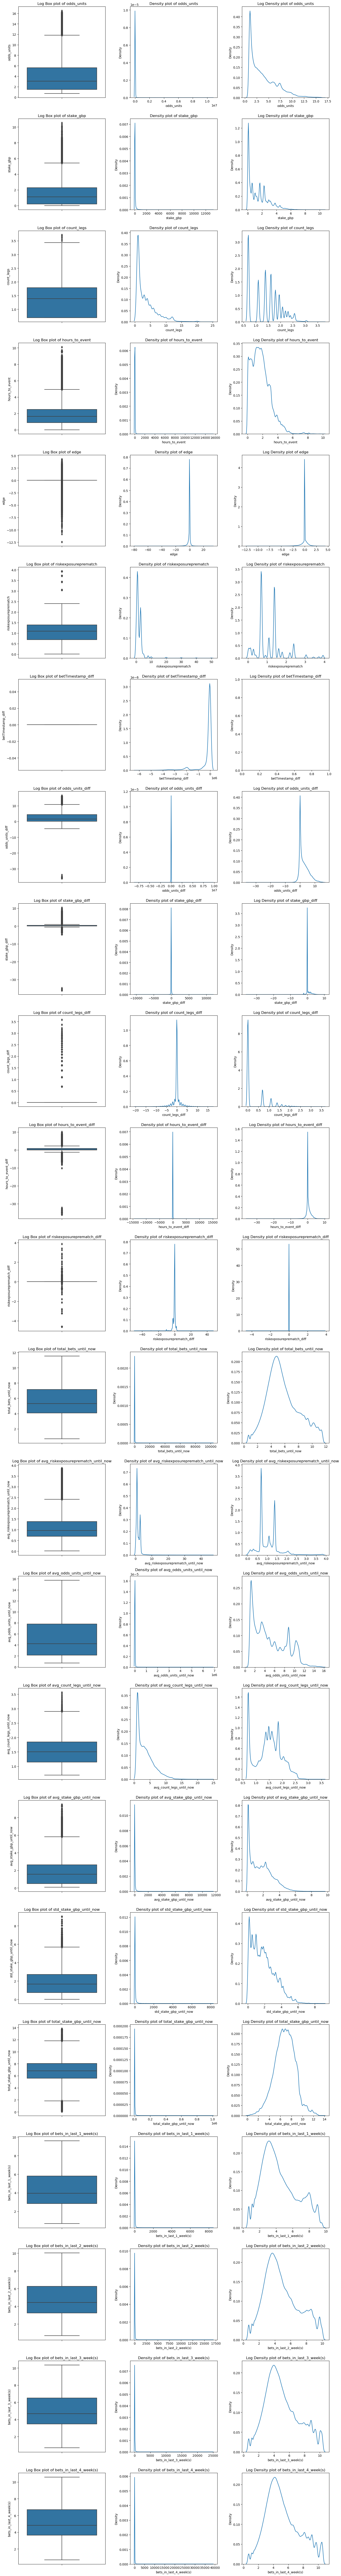

In [27]:
features = ['odds_units', 'stake_gbp', 'count_legs', 'hours_to_event', 'edge', 'riskexposureprematch', 'betTimestamp_diff', 'odds_units_diff',
            'stake_gbp_diff', 'count_legs_diff', 'hours_to_event_diff',
            'riskexposureprematch_diff', 'total_bets_until_now', 'avg_riskexposureprematch_until_now', 
            'avg_odds_units_until_now', 'avg_count_legs_until_now', 'avg_stake_gbp_until_now', 'std_stake_gbp_until_now', 'total_stake_gbp_until_now', 
            'bets_in_last_1_week(s)', 'bets_in_last_2_week(s)', 'bets_in_last_3_week(s)', 'bets_in_last_4_week(s)']



# Create subplots for each feature
fig, axs = plt.subplots(len(features), 3, figsize=(15, len(features)*5))

log_plot_df = np.log1p(merged_df[features])

for i, feature in enumerate(features):
    # Create boxplots
    sns.boxplot(y=log_plot_df[feature], ax=axs[i, 0])
    axs[i, 0].set_title(f'Log Box plot of {feature}')
    
    # Create density plots
    sns.kdeplot(data=plot_df, x=feature, ax=axs[i, 1])
    axs[i, 1].set_title(f'Density plot of {feature}')

    # Create log density plots
    sns.kdeplot(data=log_plot_df, x=feature, ax=axs[i, 2])
    axs[i, 2].set_title(f'Log Density plot of {feature}')

plt.tight_layout()
plt.show()


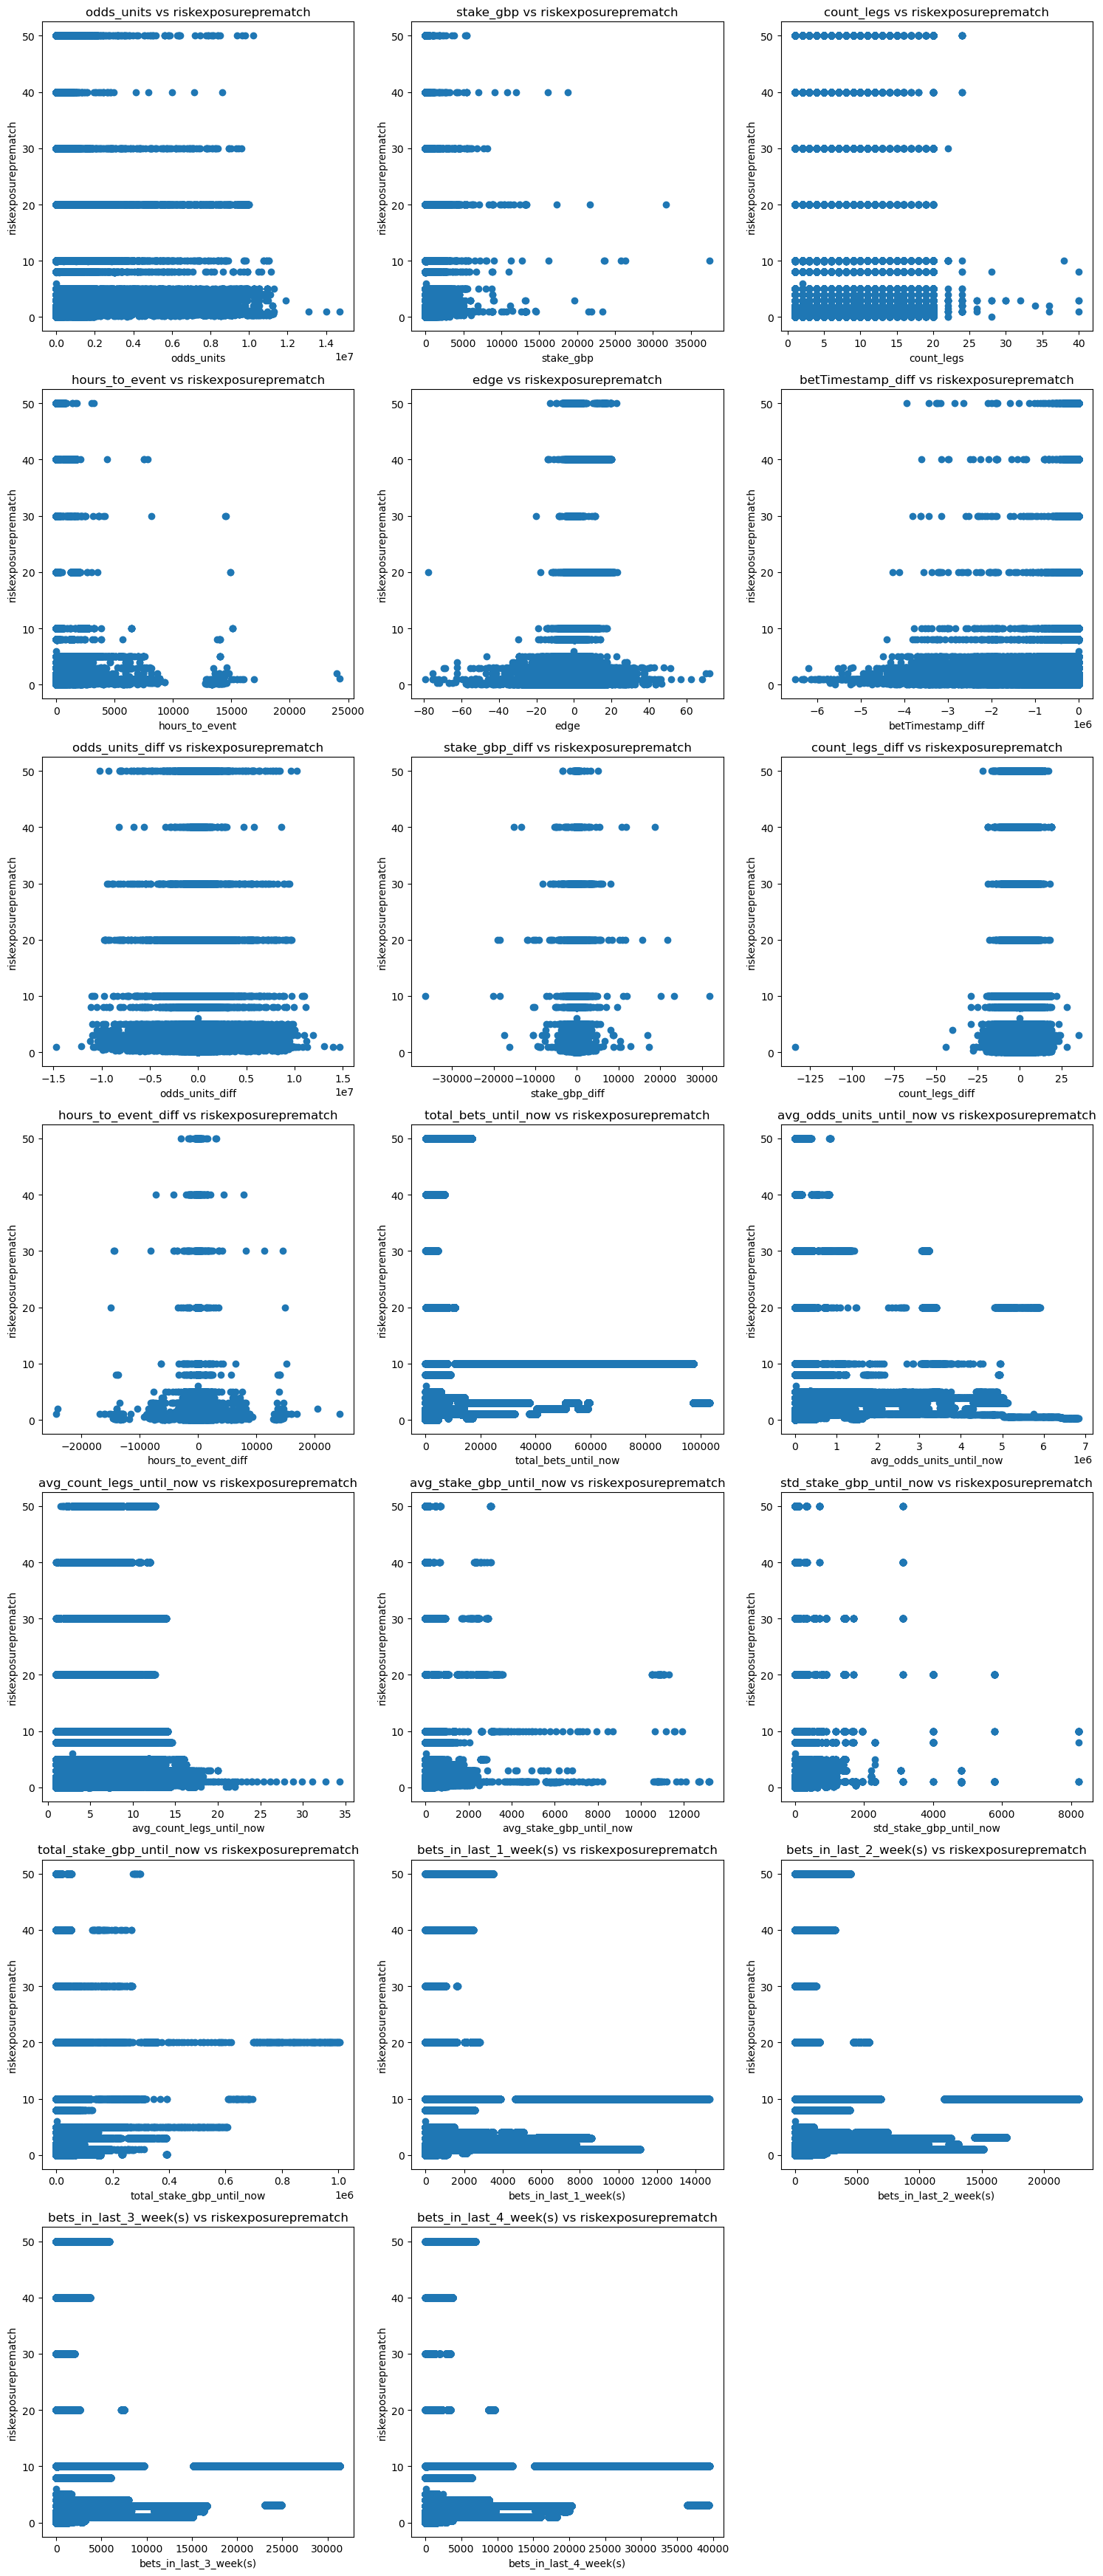

In [ ]:
features = ['odds_units', 'stake_gbp', 'count_legs', 'hours_to_event', 'edge', 'betTimestamp_diff', 'odds_units_diff', 
            'stake_gbp_diff', 'count_legs_diff', 'hours_to_event_diff',
            'total_bets_until_now',
            'avg_odds_units_until_now', 'avg_count_legs_until_now', 'avg_stake_gbp_until_now', 'std_stake_gbp_until_now', 'total_stake_gbp_until_now', 
            'bets_in_last_1_week(s)', 'bets_in_last_2_week(s)', 'bets_in_last_3_week(s)', 'bets_in_last_4_week(s)']


# Decide the number of plots per row
plots_per_row = 3
num_rows = int(np.ceil(len(features) / plots_per_row))

# Create subplots
fig, axs = plt.subplots(num_rows, plots_per_row, figsize=(15, num_rows*5))

for i, feature in enumerate(features):
    row = i // plots_per_row
    col = i % plots_per_row

    # Scatter plot with 'riskexposureprematch'
    axs[row, col].scatter(merged_df[feature], merged_df['riskexposureprematch'])
    axs[row, col].set_title(f'{feature} vs riskexposureprematch')
    axs[row, col].set_xlabel(feature)
    axs[row, col].set_ylabel('riskexposureprematch')

# If there are any unused subplot axes, hide them
for i in range(len(features), num_rows * plots_per_row):
    row = i // plots_per_row
    col = i % plots_per_row
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()


## Finding labelling criteria

After looking at the various plots, there aren't many natural separations that are immediately useful apart from riskexposureprematch, for which there are far fewer with higher values. Considering this is also the target variable I am going to start with finding a threhsold based on the log/raw plots. Following this, I will see how the 2 groups of data are separated and if any other separation criteria are needed.

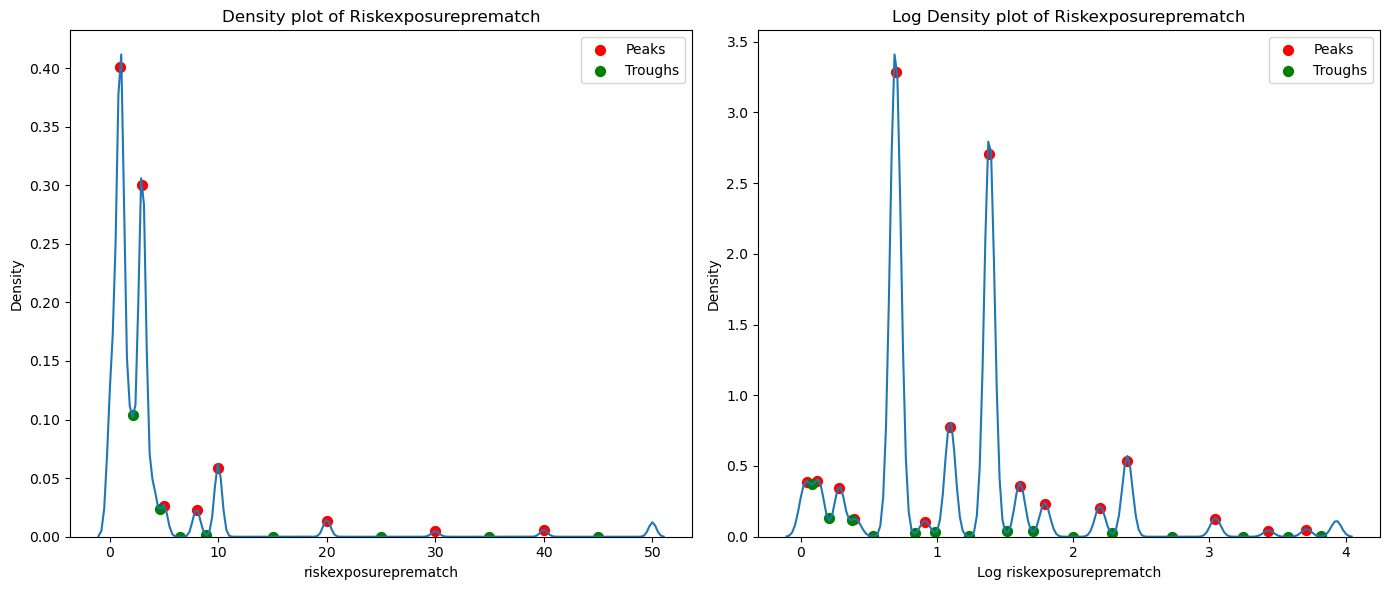

In [8]:
riskexposure_df = merged_df['riskexposureprematch']

# log1p (i.e., log(1 + x)) instead of log(x) to avoid errors when dealing with very small values of x.

log_riskexposure_df = np.log1p(riskexposure_df)

# Fit a kernel density estimate to your data
kde = gaussian_kde(riskexposure_df, bw_method='silverman')
log_kde = gaussian_kde(log_riskexposure_df, bw_method='silverman')

# Create a range of x values spanning the range of your data
x = np.linspace(riskexposure_df.min(), riskexposure_df.max(), 1000)
log_x = np.linspace(log_riskexposure_df.min(), log_riskexposure_df.max(), 1000)

# Evaluate the KDE for each x value
y = kde.evaluate(x)
log_y = log_kde.evaluate(log_x)

# Find the x values corresponding to local minima (troughs) and maxima (peaks) in the KDE
troughs_x = x[argrelextrema(y, np.less)]
peaks_x = x[argrelextrema(y, np.greater)]
log_troughs_x = log_x[argrelextrema(log_y, np.less)]
log_peaks_x = log_x[argrelextrema(log_y, np.greater)]

# Calculate y values for the peaks and troughs
troughs_y = kde.evaluate(troughs_x)
peaks_y = kde.evaluate(peaks_x)
log_troughs_y = log_kde.evaluate(log_troughs_x)
log_peaks_y = log_kde.evaluate(log_peaks_x)

# Create subplots for each feature
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Create density plots
sns.kdeplot(data=riskexposure_df, ax=axs[0])
axs[0].set_title(f'Density plot of Riskexposureprematch')

# Create log density plots
sns.kdeplot(data=log_riskexposure_df, ax=axs[1])
axs[1].set_title(f'Log Density plot of Riskexposureprematch')

# Plot the peaks
axs[0].scatter(peaks_x, peaks_y, color='r', s=50, label='Peaks')
axs[1].scatter(log_peaks_x, log_peaks_y, color='r', s=50, label='Peaks')

# Plot the troughs
axs[0].scatter(troughs_x, troughs_y, color='g', s=50, label='Troughs')
axs[1].scatter(log_troughs_x, log_troughs_y, color='g', s=50, label='Troughs')

axs[0].set_xlabel('riskexposureprematch')
axs[0].set_ylabel('Density')
axs[1].set_xlabel('Log riskexposureprematch')
axs[1].set_ylabel('Density')
axs[0].legend()
axs[1].legend()

plt.tight_layout()
plt.show()


In [9]:
print(troughs_x) # get second trough
print(log_troughs_x[7])

[ 2.16172172  4.61368368  6.51520521  8.91712713 15.02201201 25.03002002
 34.98798799 44.995996  ]
1.5135321532922608


In [10]:
np.expm1(1.5135321532922608)

3.542748172657518

# Test Label based solely on 'riskexposureprematch'

In [11]:
labelled_df = merged_df.copy()

threshold = 3.54274817 # took lower of estimated troughs

# Use np.where to create new column 'high_net_worth'. It will be 1 if 'riskexposureprematch' is greater than the threshold, and 0 otherwise.
labelled_df['high_net_worth'] = np.where(labelled_df['riskexposureprematch'] > threshold, 1, 0)

In [12]:
labelled_df['high_net_worth'].value_counts()

0    2063368
1     412697
Name: high_net_worth, dtype: int64

In [13]:
# labelled_df.to_csv('labelled_df.csv', index=False)

Roughly 16.67% of bets are labelled as high net worth using threshold of 3.54274817 on riskexposureprematch.

In [14]:
test_lbls = labelled_df[['encrypted_user_no', 'betTimestamp', 'high_net_worth']]
test_lbls.drop_duplicates(inplace=True)
# Sort by 'betTimestamp' or whatever your timestamp column is called
test_lbls.sort_values('betTimestamp', inplace=True)
# Drop duplicates, keeping the last occurrence (which will be the latest due to the sorting)
test_lbls.drop_duplicates(subset='encrypted_user_no', keep='last', inplace=True)
test_lbls['high_net_worth'].value_counts()


/var/folders/yz/86sy0w0519d250z0rfq2qx5w0000gp/T/ipykernel_11108/1535087170.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_lbls.drop_duplicates(inplace=True)
/var/folders/yz/86sy0w0519d250z0rfq2qx5w0000gp/T/ipykernel_11108/1535087170.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_lbls.sort_values('betTimestamp', inplace=True)
/var/folders/yz/86sy0w0519d250z0rfq2qx5w0000gp/T/ipykernel_11108/1535087170.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

0    13528
1     1303
Name: high_net_worth, dtype: int64

Roughly 8% of customers are labelled as high value using threshold of 5.77991028 on riskexposureprematch.

## Label Analysis

Below was taking too long

In [15]:
# features = ['odds_units', 'stake_gbp', 'count_legs', 'hours_to_event', 'riskexposureprematch', 'total_bets_until_now', 'avg_riskexposureprematch_until_now', 
#             'avg_odds_units_until_now', 'avg_stake_gbp_until_now', 'std_stake_gbp_until_now', 'total_stake_gbp_until_now', 
#             'bets_in_last_1_week(s)', 'bets_in_last_2_week(s)', 'bets_in_last_3_week(s)', 'bets_in_last_4_week(s)']

# hnw_cust_df = lbl_test_1[lbl_test_1['high_net_worth']==1]
# lnw_cust_df = lbl_test_1[lbl_test_1['high_net_worth']==0]

# from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency
    
# def compare_groups(df1, df2, features):
#     for feature in features:
#         group1 = df1[feature]
#         group2 = df2[feature]

#         # Precomputed values
#         x_values = pd.Series([1] * len(group1) + [2] * len(group2))
#         y_values = pd.concat([group1, group2], axis=0)

#         fig, axs = plt.subplots(2, 2, figsize=(20, 12))

#         # Boxplots
#         sns.boxplot(x=x_values, y=y_values, orient='v', ax=axs[0, 0])
#         axs[0, 0].set_title(f'Boxplot of {feature}')
#         axs[0, 0].set_xlabel('Group')
#         axs[0, 0].set_ylabel(feature)
#         axs[0, 0].set_xticklabels(['High Net Worth', 'Low Net Worth'])

#         # Histograms
#         sns.histplot(data=y_values, kde=False, ax=axs[0, 1])
#         axs[0, 1].set_title(f'Histogram of {feature}')
#         axs[0, 1].set_xlabel(feature)
#         axs[0, 1].set_ylabel('Count')
#         axs[0, 1].legend(['High Net Worth', 'Low Net Worth'])

#         # Density plots
#         sns.kdeplot(data=group1, ax=axs[1, 0])
#         sns.kdeplot(data=group2, ax=axs[1, 0])
#         axs[1, 0].set_title(f'Density Plot of {feature}')
#         axs[1, 0].set_xlabel(feature)
#         axs[1, 0].set_ylabel('Density')
#         axs[1, 0].legend(['High Net Worth', 'Low Net Worth'])

#         # Violin plots
#         sns.violinplot(x=x_values, y=y_values, orient='v', ax=axs[1, 1])
#         axs[1, 1].set_title(f'Violin Plot of {feature}')
#         axs[1, 1].set_xlabel('Group')
#         axs[1, 1].set_ylabel(feature)
#         axs[1, 1].set_xticklabels(['High Net Worth', 'Low Net Worth'])

#         # Statistical tests
#         if group1.dtype == 'object' or group2.dtype == 'object':
#             chi2, p_value, _, _ = chi2_contingency(pd.crosstab(group1, group2))
#             axs[1, 1].set_title(f'Chi-square test: chi2 = {chi2:.2f}, p-value = {p_value:.4f}')
#         else:
#             t_statistic, p_value = ttest_ind(group1, group2)
#             mwu_statistic, mwu_p_value = mannwhitneyu(group1, group2, alternative='two-sided')
#             axs[1, 1].set_title(f'T-test: t-statistic = {t_statistic:.2f}, p-value = {p_value:.4f}' +
#                                 f'Mann-Whitney U test: statistic = {mwu_statistic:.2f}, p-value = {mwu_p_value:.4f}')

#         plt.tight_layout()
#         plt.show()

# # Call the function
# compare_groups(hnw_cust_df, lnw_cust_df, features)


/opt/miniconda3/envs/DSML00/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log1p
  result = func(self.values, **kwargs)
/opt/miniconda3/envs/DSML00/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)
/var/folders/yz/86sy0w0519d250z0rfq2qx5w0000gp/T/ipykernel_11108/137172512.py:38: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=hnw_log[feature], ax=axs[i, 2], label='High Net Worth')
/var/folders/yz/86sy0w0519d250z0rfq2qx5w0000gp/T/ipykernel_11108/137172512.py:39: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=lnw_log[feature], ax=axs[i, 2], label='Low Net Worth')
No artists with labels found to put in legend.  Note that artists whose label start with an 

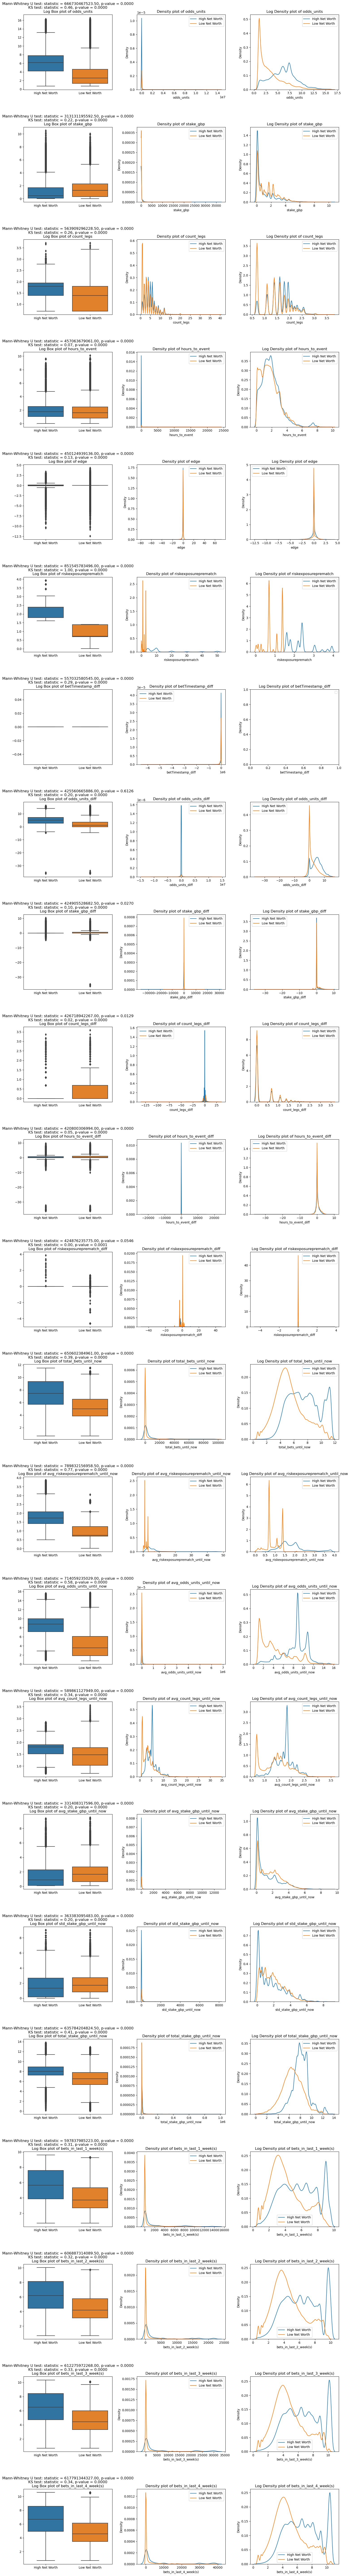

In [29]:
features = ['odds_units', 'stake_gbp', 'count_legs', 'hours_to_event', 'edge', 'riskexposureprematch', 'betTimestamp_diff', 'odds_units_diff',
            'stake_gbp_diff', 'count_legs_diff', 'hours_to_event_diff',
            'riskexposureprematch_diff', 'total_bets_until_now', 'avg_riskexposureprematch_until_now', 
            'avg_odds_units_until_now', 'avg_count_legs_until_now', 'avg_stake_gbp_until_now', 'std_stake_gbp_until_now', 'total_stake_gbp_until_now', 
            'bets_in_last_1_week(s)', 'bets_in_last_2_week(s)', 'bets_in_last_3_week(s)', 'bets_in_last_4_week(s)']

hnw_cust_df = labelled_df[labelled_df['high_net_worth']==1][features]
lnw_cust_df = labelled_df[labelled_df['high_net_worth']==0][features]

hnw_log = np.log1p(hnw_cust_df)
lnw_log = np.log1p(lnw_cust_df)

from scipy.stats import mannwhitneyu, ks_2samp

# Create subplots for each feature
fig, axs = plt.subplots(len(features), 3, figsize=(15, len(features)*5))

for i, feature in enumerate(features):
    # Compute statistics before plotting
    mwu_statistic, mwu_p_value = mannwhitneyu(hnw_cust_df[feature], lnw_cust_df[feature])
    ks_statistic, ks_p_value = ks_2samp(hnw_cust_df[feature], lnw_cust_df[feature])


    # Create boxplots for both high and low net worth customers
    sns.boxplot(data=[hnw_log[feature], lnw_log[feature]], ax=axs[i, 0])
    axs[i, 0].set_title(f'Mann-Whitney U test: statistic = {mwu_statistic:.2f}, p-value = {mwu_p_value:.4f}\n' +
                        f'KS test: statistic = {ks_statistic:.2f}, p-value = {ks_p_value:.4f}\n' +
                        f'Log Box plot of {feature}')
    axs[i, 0].set_xticklabels(['High Net Worth', 'Low Net Worth'])

    # Create density plots for both high and low net worth customers
    sns.kdeplot(x=hnw_cust_df[feature], ax=axs[i, 1], label='High Net Worth')
    sns.kdeplot(x=lnw_cust_df[feature], ax=axs[i, 1], label='Low Net Worth')
    axs[i, 1].set_title(f'Density plot of {feature}')
    axs[i, 1].legend()

    # Create log density plots for both high and low net worth customers
    sns.kdeplot(x=hnw_log[feature], ax=axs[i, 2], label='High Net Worth')
    sns.kdeplot(x=lnw_log[feature], ax=axs[i, 2], label='Low Net Worth')
    axs[i, 2].set_title(f'Log Density plot of {feature}')
    axs[i, 2].legend()

plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.show()


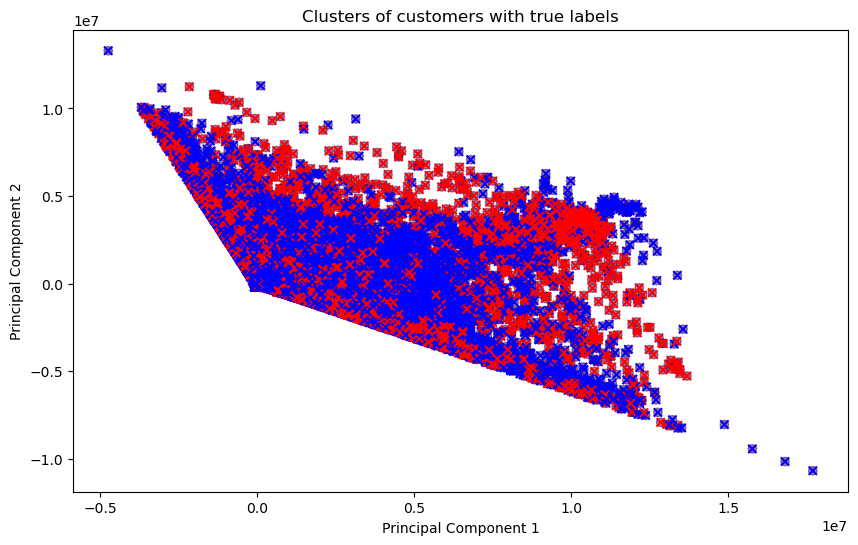

In [33]:
### Clustering analysis for bets
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.impute import SimpleImputer

colns_to_drop = [ 'total_bets', 'avg_riskexposureprematch',
       'avg_odds_units', 'avg_stake_gbp', 'total_stake_gbp', 'month', 'day',
       'day_of_week', 'hour', 'bet_sequence_count', 'total_bets_in_sequence', 'num_sequences_until_now',
       'num_bets_in_prev_sequence', 'time_diff_of_riskexposure']

# Drop the specified columns
df_data = labelled_df.drop(colns_to_drop, axis=1)

# Select only numeric columns
numeric_columns = df_data.select_dtypes(include=['float64', 'int64']).columns

# Exclude the non-numeric columns and target variable
data = df_data[numeric_columns].drop('high_net_worth', axis=1)

# Impute missing values with mean
imputer = SimpleImputer(strategy='mean')
data = imputer.fit_transform(data)

# Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Use PCA for dimensionality reduction to two dimensions for visualisation
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=5)
clusters = dbscan.fit_predict(principal_components)

# Create a color map for true labels
colors = labelled_df['high_net_worth'].map({0: 'blue', 1: 'red'})

# Filter out missing labels
filtered_colors = colors[~colors.isna()]

# Visualise clusters
plt.figure(figsize=(10, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.scatter(principal_components[~colors.isna(), 0], principal_components[~colors.isna(), 1], c=filtered_colors, marker='x')
plt.title('Clusters of customers with true labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

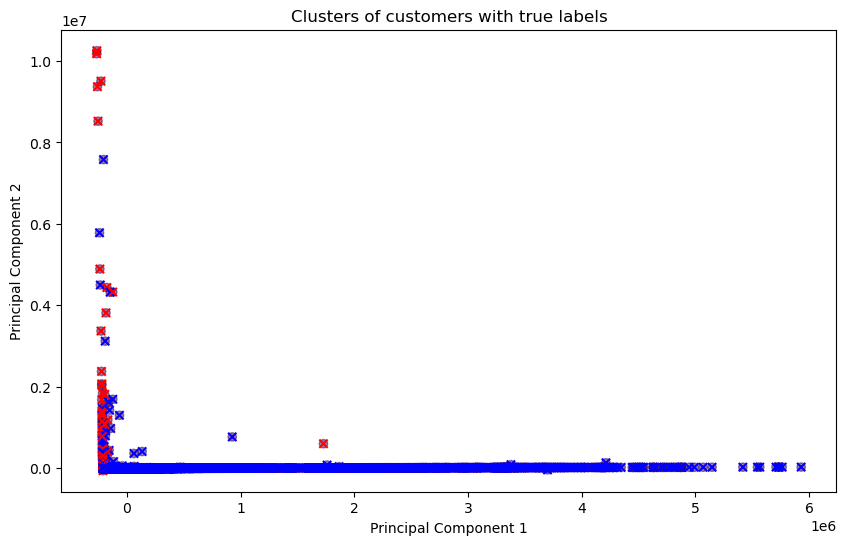

In [35]:
### Clustering analysis for users
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.impute import SimpleImputer

# Columns to drop
colns_to_drop = ['total_bets', 'avg_riskexposureprematch', 'avg_odds_units', 'avg_stake_gbp', 
                   'total_stake_gbp', 'month', 'day', 'day_of_week', 'hour', 'bet_sequence_count', 
                   'total_bets_in_sequence', 'num_sequences_until_now', 'num_bets_in_prev_sequence', 
                   'time_diff_of_riskexposure']

# Drop the specified columns
user_data = labelled_df.drop(colns_to_drop, axis=1)

# Filter to keep only one row per user
user_data = user_data.drop_duplicates(subset='encrypted_user_no', keep='last')

# Select only numeric columns
numeric_columns = user_data.select_dtypes(include=['float64', 'int64']).columns

# Exclude the non-numeric columns and target variable
data = user_data[numeric_columns].drop('high_net_worth', axis=1)

# Impute missing values with mean
imputer = SimpleImputer(strategy='mean')
data = imputer.fit_transform(data)

# Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Use PCA for dimensionality reduction to two dimensions for visualisation
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=5)
clusters = dbscan.fit_predict(principal_components)

# Create a color map for true labels
colors = user_data['high_net_worth'].map({0: 'blue', 1: 'red'})

# Filter out missing labels
filtered_colors = colors[~colors.isna()]

# Visualise clusters
plt.figure(figsize=(10, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.scatter(principal_components[~colors.isna(), 0], principal_components[~colors.isna(), 1], c=filtered_colors, marker='x')
plt.title('Clusters of customers with true labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()